<a href="https://colab.research.google.com/github/msharovar/ECGR6119/blob/main/midterm_gan_msharova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading model./training_checkpoints/ckpt-30


AssertionError: ignored

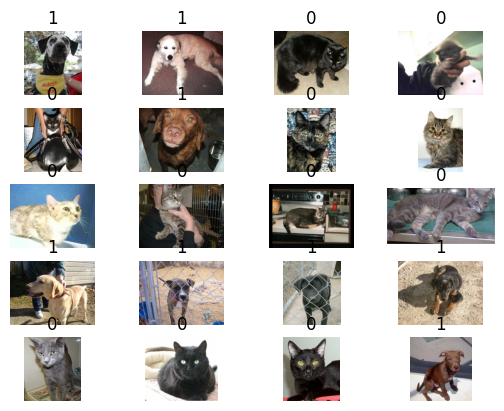

In [36]:
import tensorflow as tf
import math
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPool2D, Dense, Flatten, Dropout
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
#from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
import os
import shutil
import zipfile
from random import seed
from random import random
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tqdm import tqdm

def residual_block_generator():
  model=tf.keras.Sequential([
  tf.keras.layers.Conv2D(64,3,strides=(1,1),padding='same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Conv2D(64,3,strides=(1,1),padding='same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(),
  ])
  return model

def generator_model():
  # k9n64s1
  input = tf.keras.layers.Input(shape=(None,None,3))
  input_conv_layer = tf.keras.layers.Conv2D(64,9,padding='same')(input)
  input_conv_layer = tf.keras.layers.LeakyReLU()(input_conv_layer)
  output_layer_1 = input_conv_layer

  # Five Residual Blocks k3n64s1
  for x in range(5):
    residual_output = residual_block_generator()(output_layer_1)
    # Elementwise Sum
    output_layer_1 = tf.keras.layers.Add()([output_layer_1,residual_output])

  # k3n64s1
  output_layer_1 = tf.keras.layers.Conv2D(64,9,padding='same')(output_layer_1)
  output_layer_1 = tf.keras.layers.BatchNormalization()(output_layer_1)
  # Elementwise Sum
  output_layer_1 = tf.keras.layers.Add()([output_layer_1,input_conv_layer])

  # Upsample Block 1 k3n256s1
  upsample_layer_1 = tf.keras.layers.Conv2D(256,3, strides=(1,1),padding='same')(output_layer_1)
  upsample_layer_1 = tf.nn.depth_to_space(upsample_layer_1, 2)
  upsample_layer_1 = tf.keras.layers.LeakyReLU()(upsample_layer_1)

  # Upsample Block 2 k3n256s1
  upsample_layer_2 = tf.keras.layers.Conv2D(256,3, strides=(1,1),padding='same')(upsample_layer_1)
  upsample_layer_2 = tf.nn.depth_to_space(upsample_layer_2, 2)
  upsample_layer_2 = tf.keras.layers.LeakyReLU()(upsample_layer_2)

  # Output layer k9n3s1
  output_layer_2 = tf.keras.layers.Conv2D(3,9,activation='tanh',padding='same')(upsample_layer_2)
  generator = tf.keras.models.Model(input, output_layer_2)

  #generator.summary()
  return generator

def discriminator_model():
  # k3n64s1
  input = tf.keras.layers.Input(shape=(128,128,3))
  input_conv_layer = tf.keras.layers.Conv2D(64,3,padding='same')(input)
  input_conv_layer = tf.keras.layers.LeakyReLU()(input_conv_layer)

  # Residual Layer 1 k3n64s2
  residual_layer_1 = tf.keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(input_conv_layer)
  residual_layer_1 = tf.keras.layers.BatchNormalization()(residual_layer_1)
  residual_layer_1 = tf.keras.layers.LeakyReLU()(residual_layer_1)

  # Residual Layer 2 k3n128s1
  residual_layer_2 = tf.keras.layers.Conv2D(128,3,strides=(1,1),padding='same')(residual_layer_1)
  residual_layer_2 = tf.keras.layers.BatchNormalization()(residual_layer_2)
  residual_layer_2 = tf.keras.layers.LeakyReLU()(residual_layer_2)

  # Residual Layer 3 k3n128s2
  residual_layer_3 = tf.keras.layers.Conv2D(128,3,strides=(2,2),padding='same')(residual_layer_2)
  residual_layer_3 = tf.keras.layers.BatchNormalization()(residual_layer_3)
  residual_layer_3 = tf.keras.layers.LeakyReLU()(residual_layer_3)

  # Residual Layer 4 k3n256s1
  residual_layer_4 = tf.keras.layers.Conv2D(256,3,strides=(1,1),padding='same')(residual_layer_3)
  residual_layer_4 = tf.keras.layers.BatchNormalization()(residual_layer_4)
  residual_layer_4 = tf.keras.layers.LeakyReLU()(residual_layer_4)

  # Residual Layer 5 k3n256s2
  residual_layer_5 = tf.keras.layers.Conv2D(256,3,strides=(2,2),padding='same')(residual_layer_4)
  residual_layer_5 = tf.keras.layers.BatchNormalization()(residual_layer_5)
  residual_layer_5 = tf.keras.layers.LeakyReLU()(residual_layer_5)

  # Residual Layer 6 k3n512s1
  residual_layer_6 = tf.keras.layers.Conv2D(512,3,strides=(1,1),padding='same')(residual_layer_5)
  residual_layer_6 = tf.keras.layers.BatchNormalization()(residual_layer_6)
  residual_layer_6 = tf.keras.layers.LeakyReLU()(residual_layer_6)

  # Residual Layer 7 k3n512s2
  residual_layer_7 = tf.keras.layers.Conv2D(512,3,strides=(2,2),padding='same')(residual_layer_6)
  residual_layer_7 = tf.keras.layers.BatchNormalization()(residual_layer_7)
  residual_layer_7 = tf.keras.layers.LeakyReLU()(residual_layer_7)

  output_layer = tf.keras.layers.Flatten()(residual_layer_7)
  output_layer = tf.keras.layers.Dense(1024)(output_layer)
  output_layer = tf.keras.layers.LeakyReLU()(output_layer)
  output_layer = tf.keras.layers.Dense(1,activation='sigmoid')(output_layer)
  discriminator = tf.keras.models.Model(input,output_layer)

  #discriminator.summary()
  return discriminator

cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def build_data(data_image, data_label):
  print(data_image, data_label)
  image = tf.image.resize(data_image, [128,128])
  image = tf.divide(image, 255)
  print(image)
  #cropped=tf.dtypes.cast(tf.image.random_crop(data['image'] / 255,(128,128,3)),tf.float32)
  lr=tf.image.resize(image,(32,32))
  return (lr,image * 2 - 1)

def train_step(data,adv_ratio=0.001):
  gen_loss,disc_loss=0,0
  low_resolution,high_resolution=data
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    super_resolution = generator(low_resolution, training=True)
    gen_loss = tf.reduce_mean( (high_resolution - super_resolution) ** 2 )

    real_output = discriminator(high_resolution, training=True)
    fake_output = discriminator(super_resolution, training=True)
    adv_loss_g = generator_loss(fake_output) * adv_ratio
    gen_loss += adv_loss_g
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# get dataset that contains images of cats and dogs
train_data, validation_data, test_data = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation (from 50% to 60%) and 10% for test (from 60% to 70%)
    split=["train[:50%]", "train[50%:60%]", "train[60%:70%]"],
    as_supervised=True)

ds_img_100_to_120 = train_data.skip(100).take(20)
# display
for i, (image, label) in enumerate(iterable = ds_img_100_to_120, start = 0):
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

generator = generator_model()
discriminator = discriminator_model()

generator_optimizer=tf.keras.optimizers.Adam(0.001)
discriminator_optimizer=tf.keras.optimizers.Adam(0.001)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

latest = tf.train.latest_checkpoint(checkpoint_dir)

if latest is not None:
  print("Loading model" + latest)
  generator.load(latest)
  discriminator.load(latest)

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


noise = tf.random.normal([1, 128, 128, 3])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

for epoch in range(150):
  train_dataset_mapped = train_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE).batch(16)
  val_dataset_mapped = test_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE).batch(16)

  for image_batch in tqdm(train_dataset_mapped, position=0, leave=True):
    train_step(image_batch)
  # Save the model every 5 epochs
  if (epoch + 1) % 5 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)
  predictions = generator(noise, training=False)
  fig = plt.figure(figsize=(32, 32))

  for i in range(predictions.shape[0]):
      plt.subplot(32, 32, i+1)
      plt.imshow(predictions[i, :, :, 0])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

noise = tf.random.normal([1, 128, 128, 3])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])


# New Section